# Rechecking ampselfcal after Feb reruns


In [75]:
noisedir = "/orange/adamginsburg/ALMA_IMF/reduction/reduction/noise_estimation_regions/"

In [76]:
from spectral_cube import SpectralCube

In [77]:
import warnings
import spectral_cube
warnings.simplefilter('ignore', spectral_cube.utils.BeamWarning)
warnings.simplefilter('ignore', spectral_cube.utils.StokesWarning)
warnings.simplefilter('ignore', spectral_cube.utils.PossiblySlowWarning)
warnings.simplefilter('ignore', spectral_cube.utils.WCSWarning)

In [78]:
%matplotlib inline
import numpy as np
from astropy import units as u
import pylab as pl
pl.style.use('dark_background')
pl.rcParams['figure.figsize'] = (16,5)
pl.rcParams['image.origin'] = 'lower'
import sys
import glob
sys.path.append('/orange/adamginsburg/ALMA_IMF/reduction/reduction/')
sys.path.append('/orange/adamginsburg/ALMA_IMF/reduction/analysis/')
import imp, diagnostic_images
imp.reload(diagnostic_images)
from diagnostic_images import load_images, show
from spectral_cube import SpectralCube
import spectral_cube
from astropy.visualization import simple_norm
import regions
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [79]:
def compare_withamp_withoutamp(withamp, withoutamp, noisereg, zoom=slice(None), max_percent=99.9, min_percent=None, stretch='asinh',
                               noise_threshold=3, shrink=0.85, cmap='viridis', diffnorm=None, scalebar=5*u.arcsec):
    noamp = SpectralCube.read(withoutamp).to(u.mJy)
    withamp = SpectralCube.read(withamp).to(u.mJy)
    
    
    reg = regions.read_ds9(noisereg)
    
    noise_noamp = noamp.subcube_from_regions(reg).mad_std()
    noise_withamp = withamp.subcube_from_regions(reg).mad_std()
    print(f"Noise w/o: {noise_noamp:0.6g}")
    print(f"Noise with: {noise_withamp:0.6g}")
    print(f"Fractional difference: {(noise_noamp-noise_withamp)/noise_noamp}")
    print()
    
    noamp_dr = noamp.max()/noise_noamp
    withamp_dr = withamp.max()/noise_withamp
    print(f"Dynamic range without: {noamp_dr}")
    print(f"Dynamic range with: {withamp_dr}")
    print(f"Fractional difference (with-no)/no: {(withamp_dr-noamp_dr)/noamp_dr}")
    print()
    
    mask = (noamp > noise_noamp*noise_threshold) & (withamp > noise_withamp*noise_threshold)
    ratio = (noamp/withamp).with_mask(mask)
    print(f"Flux ratio (no amp / with amp) 25%: {ratio.percentile(25)}  50%: {ratio.median()}  75%: {ratio.percentile(75)}")
    sum_noamp = noamp.with_mask(mask).sum()
    sum_withamp = withamp.with_mask(mask).sum()
    print(f"Flux sum ratio: with/without={sum_withamp/sum_noamp}, fractional (with-without)/without={(sum_withamp-sum_noamp)/sum_noamp}")
    print()
    
    fig,((ax1,ax2,ax3)) = pl.subplots(1,3, figsize=(16,5))
    norm = simple_norm(noamp[0].value[zoom], max_percent=max_percent, min_percent=min_percent, stretch=stretch)
    im = ax1.imshow(noamp[0].value[zoom], norm=norm, cmap=cmap, origin='lower', interpolation='none')
    
    blc = np.array(noamp[0].value[zoom].shape)*0.1
    pixscale = np.abs(noamp[0].wcs.pixel_scale_matrix[0,0] * u.deg)
    scalebarlen = scalebar / pixscale
    ax1.plot([blc[1], blc[1]+scalebarlen], [blc[0], blc[0]], 'w')
    ax1.text(blc[1] + scalebarlen/2, blc[0] * 1.10, f'{scalebar.to(u.arcsec).value:0.1f}"', color='w', horizontalalignment='center')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(mappable=im, ax=ax1, cax=cax)
    cb.set_label(r'S$_\nu$ [mJy beam$^{-1}$]')
    
    ax1.set_title("No amp selfcal")
    im = ax2.imshow(withamp[0].value[zoom], norm=norm, cmap=cmap, origin='lower', interpolation='none')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(mappable=im, ax=ax2, cax=cax)
    cb.set_label(r'S$_\nu$ [mJy beam$^{-1}$]')
    
    ax2.set_title("With amp selfcal")
    diff = (noamp[0].value-withamp[0].value)[zoom]
    #im = ax3.imshow(diff, norm=simple_norm(diff, min_percent=1, max_percent=99, stretch='asinh'), cmap=cmap)
    im = ax3.imshow(diff, cmap=cmap, norm=diffnorm, origin='lower', interpolation='none')
    
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(mappable=im, ax=ax3, cax=cax)
    cb.set_label(r'S$_\nu$ [mJy beam$^{-1}$]')
    
    ax3.set_title("No amp - With amp")
    
    for ax in (ax1,ax2,ax3):
        ax.set_xticks([])
        ax.set_yticks([])
    #pl.subplots_adjust(hspace=0.05, wspace=0.05)
    
    return noamp, withamp, ratio

In [80]:
reldir = "/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release/"

In [81]:
rstimresdir = "/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/RestructuredImagingResults"
decdir = "/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/December2020Release/"

In [82]:
imdir = "/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/imaging_results/"

In [83]:
ls -d /orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release//G010.62/B3/cleanest/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal*image.tt0

/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release//G010.62/B3/cleanest/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0/


Noise w/o: 0.0852354 mJy
Noise with: 0.0834627 mJy
Fractional difference: 0.020798679666961847

Dynamic range without: 4506.383086834392
Dynamic range with: 4606.31547790649
Fractional difference (with-no)/no: 0.022175742529314667

Flux ratio (no amp / with amp) 25%: 0.9719708561897278  50%: 1.021201729774475  75%: 1.117600440979004
Flux sum ratio: with/without=0.9861669540405273, fractional (with-without)/without=-0.01383307483047247



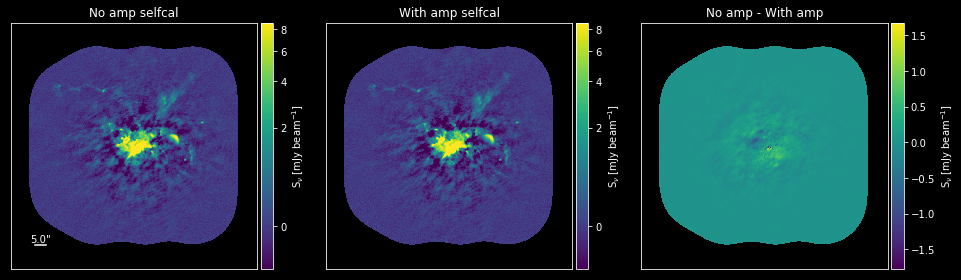

In [84]:
_=compare_withamp_withoutamp(withoutamp=f'{reldir}/G010.62/B6/cleanest/G010.62_B6_uid___A001_X1296_X1db_continuum_merged_12M_robust0_selfcal5_finaliter.image.tt0.fits',
                             withamp=f'{imdir}/G010.62_B6_uid___A001_X1296_X1db_continuum_merged_12M_robust0_selfcal4.image.tt0.fits',
                             noisereg=f"{noisedir}/G010.62_B6_noise_sampling.reg",
                             max_percent=99.5,
                             min_percent=1,
                             stretch='asinh'
                             
                            )

Noise w/o: 0.0946582 mJy
Noise with: 0.0594815 mJy
Fractional difference: 0.3716174591951395

Dynamic range without: 3039.42686225952
Dynamic range with: 4837.211628750419
Fractional difference (with-no)/no: 0.5914880824453922

Flux ratio (no amp / with amp) 25%: 0.9424992203712463  50%: 1.0086246728897095  75%: 1.1714239120483398
Flux sum ratio: with/without=0.9988921880722046, fractional (with-without)/without=-0.0011077985400334



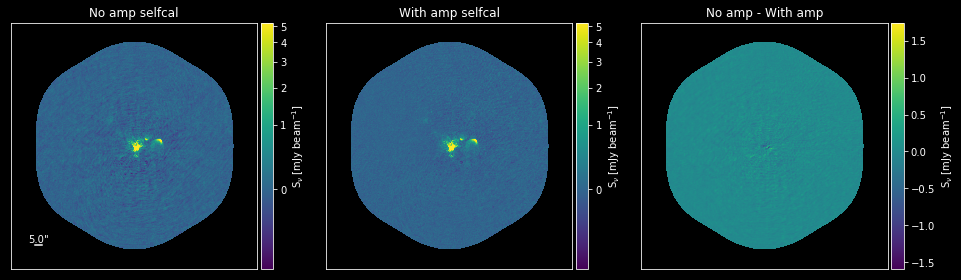

In [85]:
_=compare_withamp_withoutamp(withamp=f'{reldir}/G010.62/B3/cleanest/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.fits',
                           withoutamp=f'{imdir}/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal7.image.tt0.fits',
                           noisereg=f"{noisedir}/G010.62_B3_noise_sampling.reg",
                          )

Noise w/o: 0.0946582 mJy
Noise with: 0.0594815 mJy
Fractional difference: 0.3716174591951395

Dynamic range without: 3039.42686225952
Dynamic range with: 4837.211628750419
Fractional difference (with-no)/no: 0.5914880824453922

Flux ratio (no amp / with amp) 25%: 0.9424992203712463  50%: 1.0086246728897095  75%: 1.1714239120483398
Flux sum ratio: with/without=0.9988921880722046, fractional (with-without)/without=-0.0011077985400334



/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


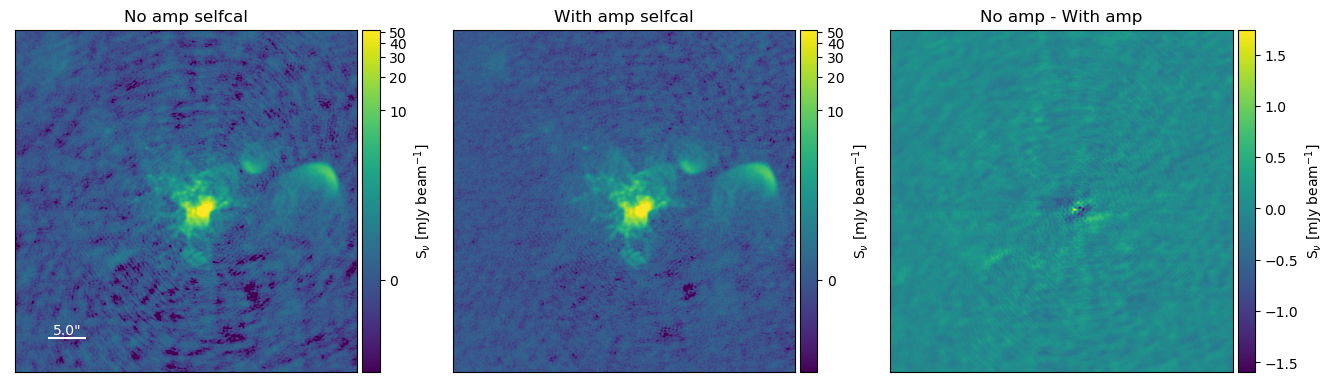

In [86]:
with pl.style.context('default'):
    _=compare_withamp_withoutamp(withamp=f'{reldir}/G010.62/B3/cleanest/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.fits',
                               withoutamp=f'{imdir}/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal7.image.tt0.fits',
                               noisereg=f"{noisedir}/G010.62_B3_noise_sampling.reg",
                                 cmap='viridis',
                               zoom=(slice(1000,-1000), slice(1000,-1000)),
                               max_percent=99.9,
                               stretch='log',
                               min_percent=1)
    pl.savefig('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/paper_figures/G010.62_B3_before_vs_after_amselfcal_zoom.pdf', bbox_inches='tight')

_=compare_withamp_withoutamp(withamp=f'{imdir}/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal8.image.tt0.fits',
                             withoutamp=f'{imdir}/G010.62_B3_uid___A001_X1296_X1e5_continuum_merged_12M_robust0_selfcal7.image.tt0.fits',
                             noisereg=f"{noisedir}/G010.62_B3_noise_sampling.reg",
                             zoom=(slice(1000,-1000), slice(1000,-1000)),
                             max_percent=99.9,
                             stretch='log',
                             min_percent=1)

In [87]:
glob.glob(f"{reldir}/G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal*image.tt0")

['/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release//G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0']

Noise w/o: 0.139147 mJy
Noise with: 0.135075 mJy
Fractional difference: 0.02926928209488287

Dynamic range without: 1580.1675148371096
Dynamic range with: 1598.1406157353733
Fractional difference (with-no)/no: 0.011374174402083239

Flux ratio (no amp / with amp) 25%: 1.0027506351470947  50%: 1.027970552444458  75%: 1.0777089595794678
Flux sum ratio: with/without=0.9833692312240601, fractional (with-without)/without=-0.016630778089165688



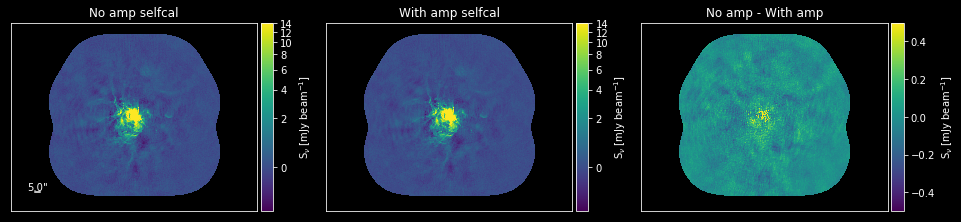

In [88]:
_=compare_withamp_withoutamp(withamp=f"{reldir}/G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                               withoutamp=f'{imdir}/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal5.image.tt0.fits',
                           noisereg=f"{noisedir}/G333.60_B3_noise_sampling.reg",
                             max_percent=99.5,
                             diffnorm=simple_norm(data=[0,1], min_cut=-0.5, max_cut=0.5)
                          )

Noise w/o: 0.139147 mJy
Noise with: 0.135075 mJy
Fractional difference: 0.02926928209488287

Dynamic range without: 1580.1675148371096
Dynamic range with: 1598.1406157353733
Fractional difference (with-no)/no: 0.011374174402083239

Flux ratio (no amp / with amp) 25%: 1.0027506351470947  50%: 1.027970552444458  75%: 1.0777089595794678
Flux sum ratio: with/without=0.9833692312240601, fractional (with-without)/without=-0.016630778089165688



(SpectralCube with shape=(1, 3000, 3920) and unit=mJy:
  n_x:   3920  type_x: RA---SIN  unit_x: deg    range:   245.479580 deg:  245.598451 deg
  n_y:   3000  type_y: DEC--SIN  unit_y: deg    range:   -50.129394 deg:  -50.071080 deg
  n_s:      1  type_s: FREQ      unit_s: Hz     range: 98615464371.690 Hz:98615464371.690 Hz,
 SpectralCube with shape=(1, 3000, 3920) and unit=mJy:
  n_x:   3920  type_x: RA---SIN  unit_x: deg    range:   245.479580 deg:  245.598451 deg
  n_y:   3000  type_y: DEC--SIN  unit_y: deg    range:   -50.129394 deg:  -50.071080 deg
  n_s:      1  type_s: FREQ      unit_s: Hz     range: 98615464371.690 Hz:98615464371.690 Hz,
 SpectralCube with shape=(1, 3000, 3920):
  n_x:   3920  type_x: RA---SIN  unit_x: deg    range:   245.479580 deg:  245.598451 deg
  n_y:   3000  type_y: DEC--SIN  unit_y: deg    range:   -50.129394 deg:  -50.071080 deg
  n_s:      1  type_s: FREQ      unit_s: Hz     range: 98615464371.690 Hz:98615464371.690 Hz)

/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


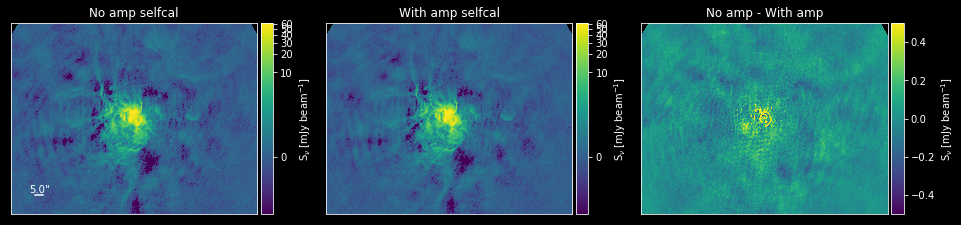

In [89]:
compare_withamp_withoutamp(withamp=f"{reldir}/G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                           withoutamp=f'{imdir}/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal5.image.tt0.fits',
                           noisereg=f"{noisedir}/G333.60_B3_noise_sampling.reg",
                           zoom=(slice(600,-600), slice(800,-800)),
                           max_percent=99.9,
                           stretch='log',
                           diffnorm=simple_norm(data=[0,1], min_cut=-0.5, max_cut=0.5),                     
                           min_percent=1)

Noise w/o: 0.119141 mJy
Noise with: 0.114712 mJy
Fractional difference: 0.037167893639182305

Dynamic range without: 2052.955935266804
Dynamic range with: 2126.4747224406133
Fractional difference (with-no)/no: 0.03581118615887625

Flux ratio (no amp / with amp) 25%: 0.9693527668714523  50%: 1.0173394680023193  75%: 1.1574791073799133
Flux sum ratio: with/without=0.9884834289550781, fractional (with-without)/without=-0.011516579426825047



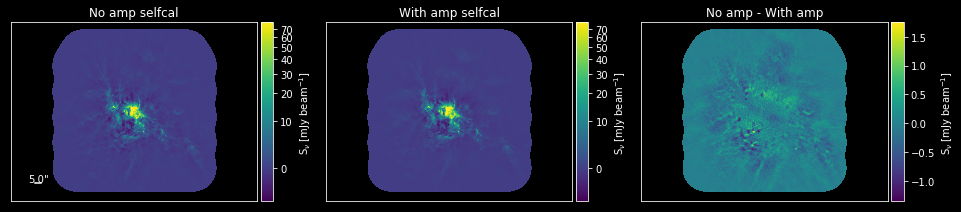

In [90]:
_=compare_withamp_withoutamp(withamp=f"{reldir}/G333.60/B6/cleanest/G333.60_B6_uid___A001_X1296_X19b_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                             withoutamp=f'{imdir}/G333.60_B6_uid___A001_X1296_X19b_continuum_merged_12M_robust0_selfcal5.image.tt0.fits',
                             noisereg=f"{noisedir}/G333.60_B6_noise_sampling.reg"
                            )

Noise w/o: 0.119141 mJy
Noise with: 0.114712 mJy
Fractional difference: 0.037167893639182305

Dynamic range without: 2052.955935266804
Dynamic range with: 2126.4747224406133
Fractional difference (with-no)/no: 0.03581118615887625

Flux ratio (no amp / with amp) 25%: 0.9693527668714523  50%: 1.0173394680023193  75%: 1.1574791073799133
Flux sum ratio: with/without=0.9884834289550781, fractional (with-without)/without=-0.011516579426825047



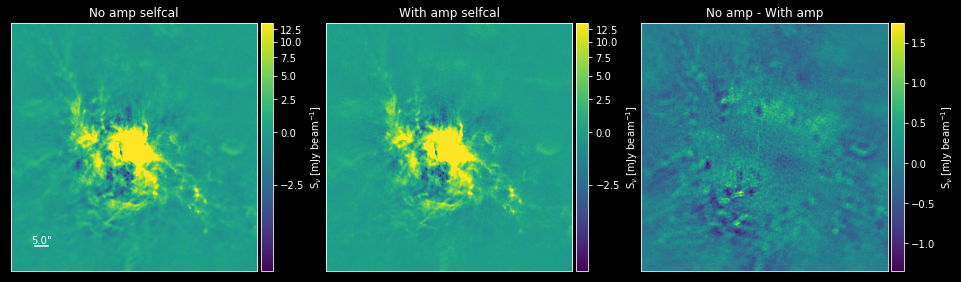

In [91]:
_=compare_withamp_withoutamp(withamp=f"{reldir}/G333.60/B6/cleanest/G333.60_B6_uid___A001_X1296_X19b_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                             withoutamp=f'{imdir}/G333.60_B6_uid___A001_X1296_X19b_continuum_merged_12M_robust0_selfcal5.image.tt0.fits',
                             noisereg=f"{noisedir}/G333.60_B6_noise_sampling.reg",
                             zoom=(slice(300,-300), slice(600,-600)),
                             max_percent=98,
                            )

Noise w/o: 0.187392 mJy
Noise with: 0.175808 mJy
Fractional difference: 0.06181722729942512

Dynamic range without: 933.1264921259852
Dynamic range with: 988.4752824043932
Fractional difference (with-no)/no: 0.059315420519574176

Flux ratio (no amp / with amp) 25%: 0.9829449951648712  50%: 1.0062874555587769  75%: 1.030359536409378
Flux sum ratio: with/without=0.9934602379798889, fractional (with-without)/without=-0.006539779249578714



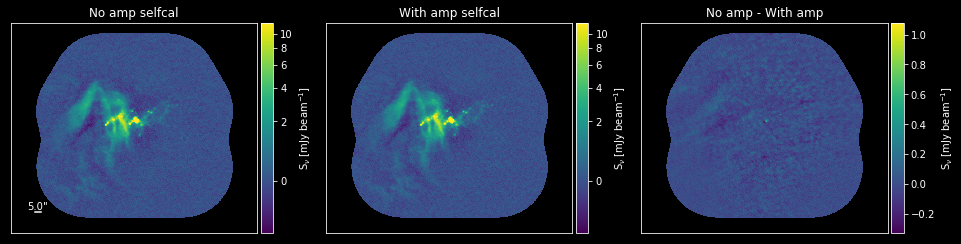

In [92]:
_=compare_withamp_withoutamp(withoutamp=f"{reldir}/G353.41/B3/cleanest/G353.41_B3_uid___A001_X1296_X1d5_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                           withamp=f"{decdir}/G353.41/B3/cleanest/G353.41_B3_uid___A001_X1296_X1d5_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                           noisereg=f"{noisedir}/G353.41_B3_noise_sampling.reg",
                           #zoom=(slice(300,-300), slice(600,-600)),
                           #max_percent=99.9,
                           #stretch='log',
                           #min_percent=0
                          )

Noise w/o: 0.418046 mJy
Noise with: 0.40756 mJy
Fractional difference: 0.02508352472765285

Dynamic range without: 268.57680302256244
Dynamic range with: 268.40724128646946
Fractional difference (with-no)/no: -0.0006313342559176373

Flux ratio (no amp / with amp) 25%: 0.9928571283817291  50%: 1.0246727466583252  75%: 1.0493897795677185
Flux sum ratio: with/without=0.9768317341804504, fractional (with-without)/without=-0.023168247193098068



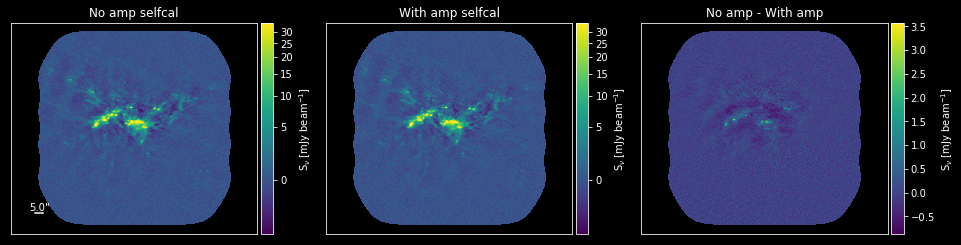

In [93]:
_=compare_withamp_withoutamp(withamp=f"{decdir}/G353.41/B6/cleanest/G353.41_B6_uid___A001_X1296_X1c9_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                           withoutamp=f"{reldir}/G353.41/B6/cleanest/G353.41_B6_uid___A001_X1296_X1c9_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
                           noisereg=f"{noisedir}/G353.41_B6_noise_sampling.reg",
                           #zoom=(slice(300,-300), slice(600,-600)),
                           #max_percent=99.9,
                           #stretch='log',
                           #min_percent=0
                          )

Noise w/o: 0.0317187 mJy
Noise with: 0.036066 mJy
Fractional difference: -0.13705640944649072

Dynamic range without: 190.48169341896522
Dynamic range with: 203.4886621053013
Fractional difference (with-no)/no: 0.06828461283010122

Flux ratio (no amp / with amp) 25%: 0.8016194701194763  50%: 0.8419809937477112  75%: 0.8994202166795731
Flux sum ratio: with/without=1.2134987115859985, fractional (with-without)/without=0.21349866688251495



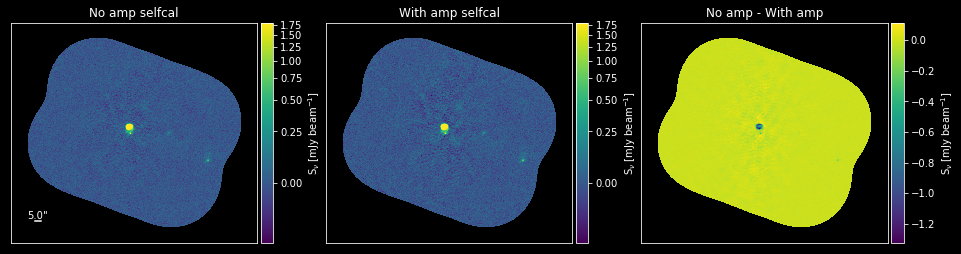

In [94]:
noamp, withamp, ratio = compare_withamp_withoutamp(
    withamp=f"{decdir}/W43-MM3/B3/cleanest/W43-MM3_B3_uid___A001_X1296_X12f_continuum_merged_12M_robust0_selfcal5_finaliter.image.tt0.fits",
    withoutamp=f"{reldir}/W43-MM3/B3/cleanest/W43-MM3_B3_uid___A001_X1296_X12f_continuum_merged_12M_robust0_selfcal5_finaliter.image.tt0.fits",
    noisereg=f"{noisedir}/W43-MM3_B3_noise_sampling.reg",
    #zoom=(slice(300,-300), slice(300,-300)),
    #max_percent=99.9,
    #stretch='log',
    #min_percent=1,
)

Noise w/o: 0.317795 mJy
Noise with: 0.221494 mJy
Fractional difference: 0.3030302756444249

Dynamic range without: 2633.883032872023
Dynamic range with: 3736.3172613140046
Fractional difference (with-no)/no: 0.41855853683824074

Flux ratio (no amp / with amp) 25%: 0.984500452876091  50%: 1.0065069198608398  75%: 1.0380683243274689
Flux sum ratio: with/without=0.9935182929039001, fractional (with-without)/without=-0.006481726188212633



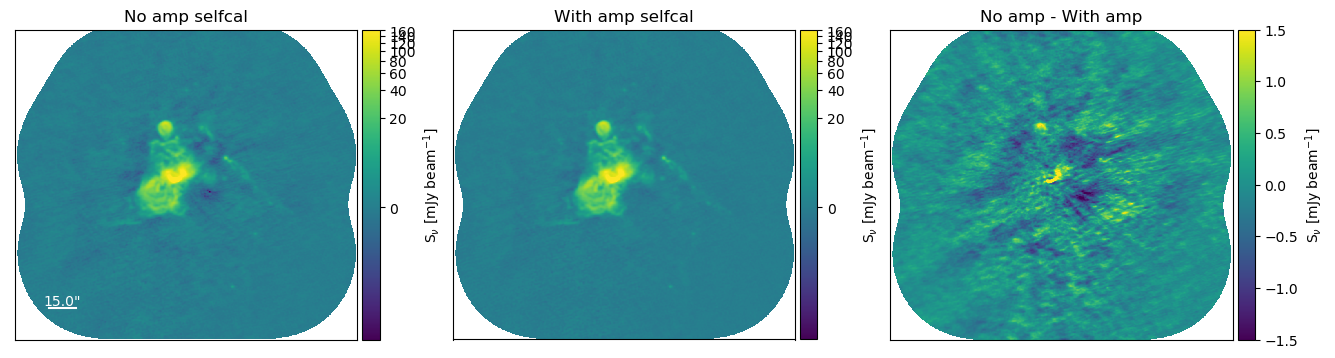

In [95]:
with pl.style.context('default'):
    noamp, withamp, ratio = compare_withamp_withoutamp(
        withoutamp=f"{rstimresdir}/G012.80/B3/cleanest/G012.80_B3_uid___A001_X1296_X1fb_continuum_merged_12M_robust0_selfcal6.image.tt0.fits",
        withamp=f"{reldir}/G012.80/B3/cleanest/G012.80_B3_uid___A001_X1296_X1fb_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.fits",
        noisereg=f"{noisedir}/G012.80_B3_noise_sampling.reg",
        zoom=(slice(100,-100), slice(60,-60)),
        #max_percent=99.9,
        scalebar=15*u.arcsec,
        stretch='log',
        #min_percent=1,
        diffnorm=simple_norm([0,1], min_cut=-1.5, max_cut=1.5)
    )
pl.savefig('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/paper_figures/G012.80_B3_before_vs_after_amselfcal_zoom.pdf', bbox_inches='tight')    

Noise w/o: 0.762249 mJy
Noise with: 0.741738 mJy
Fractional difference: 0.026908555845826406

Dynamic range without: 527.9451583006465
Dynamic range with: 536.4201380827
Fractional difference (with-no)/no: 0.01605276542232672

Flux ratio (no amp / with amp) 25%: 0.9434546828269958  50%: 1.001039743423462  75%: 1.0560004711151123
Flux sum ratio: with/without=0.9965921640396118, fractional (with-without)/without=-0.0034078455064445734



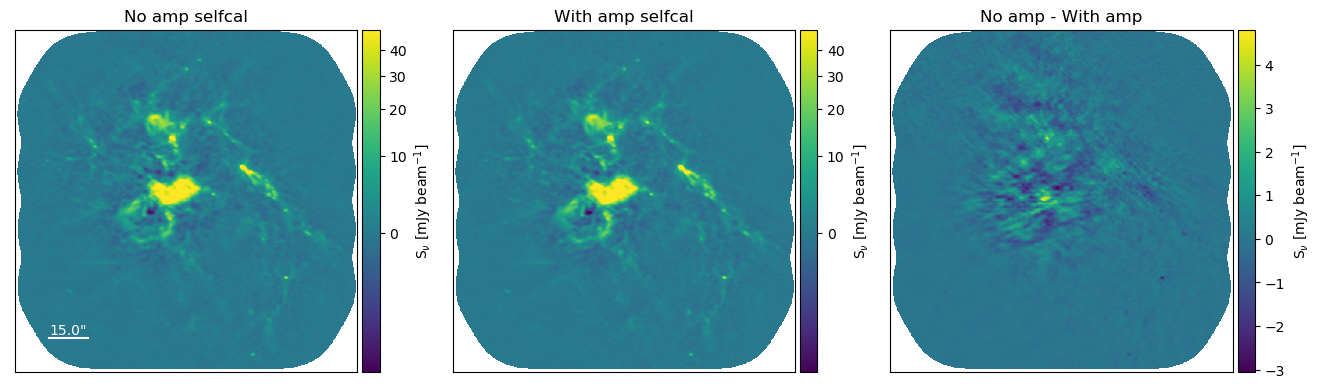

In [96]:
with pl.style.context('default'):
    noamp, withamp, ratio = compare_withamp_withoutamp(
        #withamp=   f"{decdir}/G012.80/B6/cleanest/G012.80_B6_uid___A001_X1296_X1ef_continuum_merged_12M_robust0_selfcal5_finaliter.image.tt0.fits",
        #withoutamp=f"{reldir}/G012.80/B6/cleanest/G012.80_B6_uid___A001_X1296_X1ef_continuum_merged_12M_robust0_selfcal5_finaliter.image.tt0.fits",
        withamp=f"{rstimresdir}/G012.80/B6/cleanest/G012.80_B6_uid___A001_X1296_X1ef_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits",
        withoutamp=f"{rstimresdir}/G012.80/B6/cleanest/G012.80_B6_uid___A001_X1296_X1ef_continuum_merged_12M_robust0_selfcal5.image.tt0.fits",
        noisereg=  f"{noisedir}/G012.80_B6_noise_sampling.reg",
        zoom=(slice(50,-50), slice(50,-50)),
        max_percent=99.5,
        scalebar=15*u.arcsec,
        #stretch='log',
        #min_percent=1,
    )
    pl.savefig('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/paper_figures/G012.80_B6_before_vs_after_amselfcal_zoom.pdf', bbox_inches='tight')    

Noise w/o: 0.110821 mJy
Noise with: 0.0946762 mJy
Fractional difference: 0.14568640856449652

Dynamic range without: 8054.219564885478
Dynamic range with: 9345.583048710003
Fractional difference (with-no)/no: 0.16033378199106582

Flux ratio (no amp / with amp) 25%: 0.9682392776012421  50%: 1.0172874927520752  75%: 1.0829904079437256
Flux sum ratio: with/without=0.9834595322608948, fractional (with-without)/without=-0.01654045283794403



/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


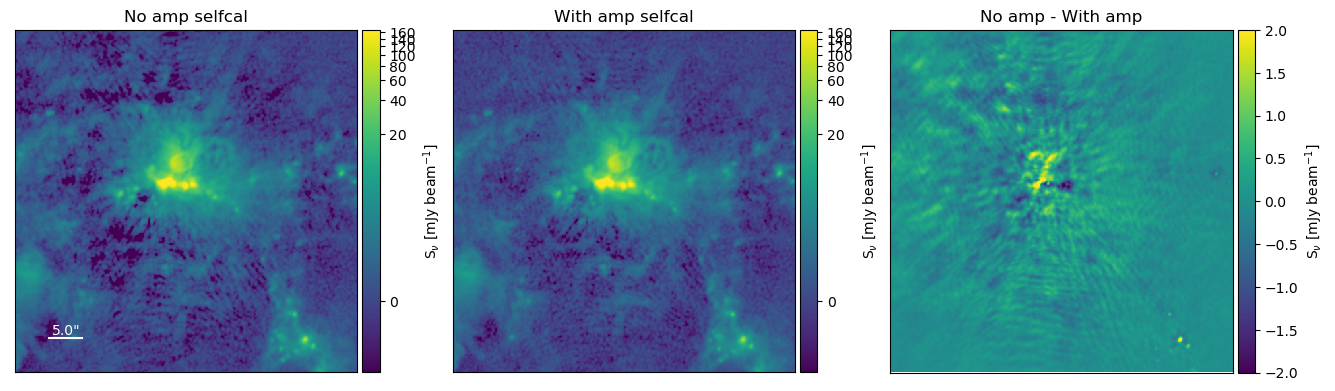

In [97]:
with pl.style.context('default'):
    noamp, withamp, ratio = compare_withamp_withoutamp(
        withamp=        f"{reldir}/W51-IRS2/B6/cleanest/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.fits",
        withoutamp=f"{rstimresdir}/W51-IRS2/B6/cleanest/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal8.image.tt0.fits",
        noisereg=     f"{noisedir}/W51-IRS2_B6_noise_sampling.reg",
        zoom=(slice(300,-300), slice(300,-300)),
        max_percent=99.9,
        stretch='log',
        min_percent=2,
        diffnorm=simple_norm([0,1], min_cut=-2, max_cut=2)
    )
    pl.savefig('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/paper_figures/W51-IRS2_B6_before_vs_after_amselfcal_zoom.pdf', bbox_inches='tight')    